In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, boxcox

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics

import re

#Warning 
import warnings
warnings.filterwarnings('ignore')


# Regression Model 

## Intro:

Hello guys, I will try to explain shortly about linear regression models. As far as there is many documentation of machine learning, here we are going to discuss about supervised model which has two types. linear regression is focused into numerical data and on the other hand, classification is related to categorical data.

Thinking in machine learning, it is to believe how machine learns. As [Autor] mention in his book, Machine learning is a subset of AI. First of all, we have to think how humans learn. There are two types of learning: 1-by logic and 2-by experience.


In [4]:
with open('./dataset/auto+mpg/auto-mpg.names') as f:
    line_clean = [line.strip() for line in f.readlines()]

with open('./dataset/auto+mpg/auto-mpg.data') as f:
    data_clean = f.readlines()

header = [re.search('[^\d][^\s]+',i).group(0)[1:-1] for i in line_clean[33:42]]
header[-1] = 'car name'
header[6] = 'model'

# Raw dataset from auto-mpg.data:

df = pd.read_fwf('./dataset/auto+mpg/auto-mpg.data', names = header)
print(df.shape)
df.head()

(398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


## Business Analysis

* Goal: 

The main idea is to predict the mpg(miles per galon) fuel consumption from a car model based on features like cylinders, horsepower, aceleration, mode, origin, etc.

* Dataset description:

- mpg: The "mpg" column represents the miles per gallon, indicating how many miles a vehicle can travel on one gallon of fuel. "mpg" is our target variable.
- cylinders: The "cylinders" column denotes the number of cylinders in the engine of the vehicle. It is a multi-valued discrete feature, indicating the count of cylinders, such as 3, 4, 5, 6, 8.
- displacement: The "displacement" column represents the total volume swept by all the cylinders in the engine. It is a continuous value and is typically measured in liters.
- horsepower: The "horsepower" column indicates the power output of the vehicle's engine. It is a continuous value, representing the strength of the engine.
- weight: The "weight" column represents the weight of the vehicle. It is a continuous value, often measured in pounds or kilograms.
- acceleration: The "acceleration" column denotes the time it takes for the vehicle to reach a certain speed. It is a continuous value, indicating the rate of change of velocity.
- model year: The "model year" column represents the year in which the vehicle was manufactured. It is a multi-valued discrete feature, indicating different years of production.
- origin: The "origin" column indicates the geographic origin or manufacturing region of the vehicle. It is a multi-valued discrete feature, representing different countries or regions.
- car model: The "car model" column specifies the unique name of each vehicle instance. It is a string feature, providing a distinct identifier for each car

# Point 0: How to explore the data?

## Cleaning

In [9]:
# During first analysis, we can see the horsepower feature is object type because has some'?' values.
df.horsepower.unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [10]:
print("Number of ? is " , len(df[df.horsepower == "?"]))

Number of ? is  6


In [11]:
# Replace '?' values by Nan values:
df.horsepower.replace('?', np.nan, inplace = True)
df.horsepower = df.horsepower.astype(float)
df[df.isnull().any(axis = 1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car name
32,25.0,4,98.0,NaN,2046.0,19.0,71,1,"""ford pinto"""
126,21.0,6,200.0,NaN,2875.0,17.0,74,1,"""ford maverick"""
330,40.9,4,85.0,NaN,1835.0,17.3,80,2,"""renault lecar deluxe"""
336,23.6,4,140.0,NaN,2905.0,14.3,80,1,"""ford mustang cobra"""
354,34.5,4,100.0,NaN,2320.0,15.8,81,2,"""renault 18i"""
374,23.0,4,151.0,NaN,3035.0,20.5,82,1,"""amc concord dl"""


Now we can work with feature "horsepower". We are going to replace "NaN" values by its mean. As can see there is one commom value for this type of value: "Cylinders = 4" and also "Cylinders = 6". So we are goint to replace with its mean:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [13]:
# As we can see most of the values are related to "ford" car model, we should get the mean of this model:
ford4_mean = df[(df.cylinders == 4) & (df["car name"].str.contains('ford'))]['horsepower'].mean()
ford4_mean = round(ford4_mean, 1)
ford4_mean

81.1

In [14]:
# As we can see most of the values are related to "ford" car model, we should get the mean of this model:
ford6_mean = df[(df.cylinders == 6) & (df["car name"].str.contains('ford'))]['horsepower'].mean()
ford6_mean = round(ford6_mean, 1)
ford6_mean

88.3

In [15]:
# By the way, we get a general mean for  whole "cylinders = 4 and cylinders = 6":
df[(df.cylinders == 4)]['horsepower'].mean(), df[(df.cylinders == 6)]['horsepower'].mean()

(78.28140703517587, 101.50602409638554)

In [16]:
# As we can see, we can use the mean of "ford" car name feature:
df.horsepower.fillna(ford4_mean, inplace = True)
df.horsepower.isnull().sum()

0

In [17]:
df[df.isnull().any(axis = 1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car name


In [18]:
# Detail of features:

# Create an empty list to store the output data
output_data = []

for col in df.columns:
    
    # If the number of unique values in the column is less than or equal to 5
    if df.loc[:, col].nunique() <= 5:
        # Get the unique values in the column
        unique_values = df.loc[:, col].unique()
        # Append the column name, number of unique values, unique values, and data type to the output data
        output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
    else:
        # Otherwise, append only the column name, number of unique values, and data type to the output data
        output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])

output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

output_df

,Column Name,Number of Unique Values,Unique Values,Data Type
0,mpg,129,-,float64
1,cylinders,5,"[8, 4, 6, 3, 5]",int64
2,displacement,82,-,float64
3,horsepower,94,-,float64
4,weight,351,-,float64
5,acceleration,95,-,float64
6,model,13,-,int64
7,origin,3,"[1, 3, 2]",int64
8,car name,305,-,object


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,104.117085,38.305448,46.0,76.000,92.0,125.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


## Exploring

### Correlation

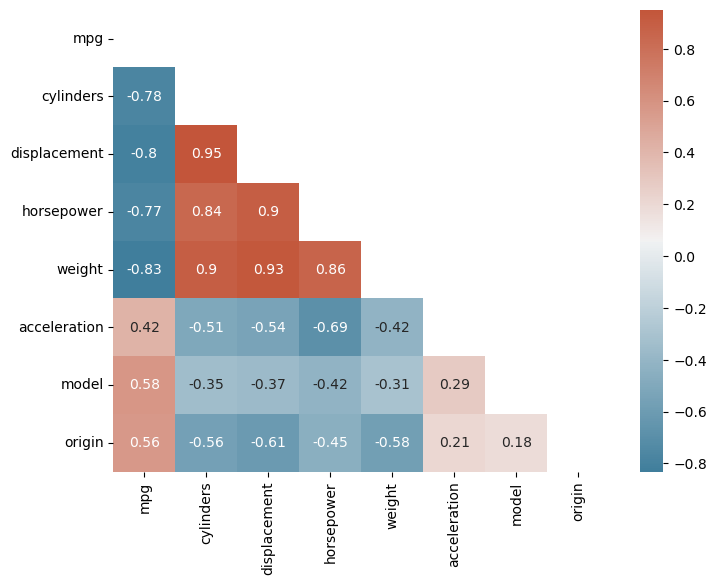

In [21]:
plt.subplots(figsize=(8, 6))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap)
plt.show()

Insghts:
- We can see that almost all important features are negative correlated to label. For example: horsepower, displacement, cylinders, weight. This means more horsepower less mpg which is logic.
- Aceleration and origin has small correlation with mpg.


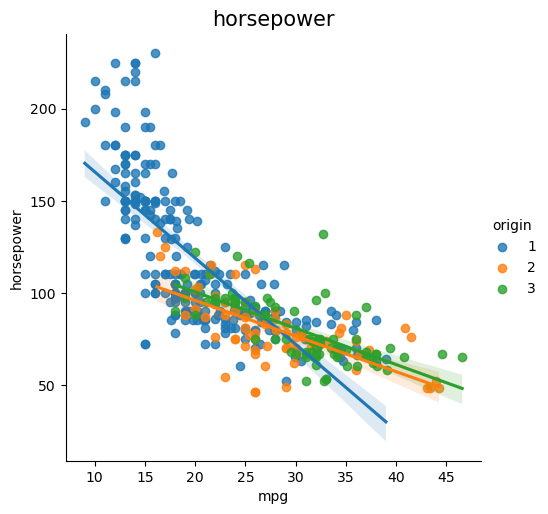

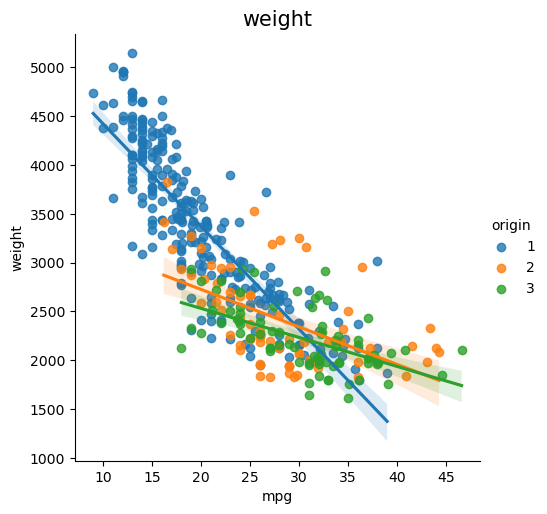

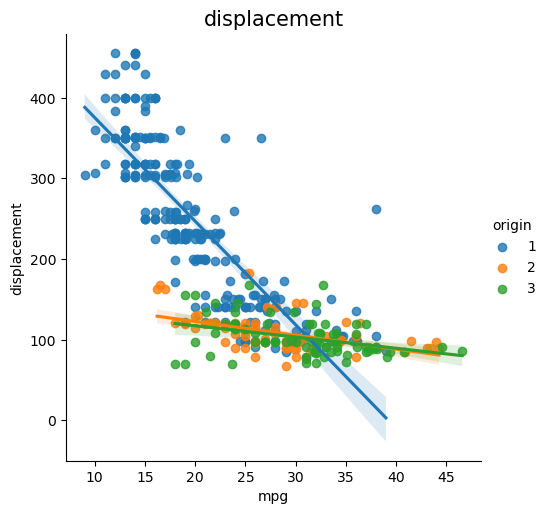

In [22]:
for i in ["horsepower","weight","displacement"]:
    plot = sns.lmplot(x = "mpg", y = i, data = df, hue = 'origin')
    plt.title(i, fontsize = 15)
    plt.show()

### Detecting Outlier

In [24]:
def detect_outlier(X):
    """
    X: dataframe
    """
    outliers = []
    for i in range(X.shape[1]-1):
        first_q = np.percentile(X[X.columns[i]], 25)
        third_q = np.percentile(X[X.columns[i]], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
        
        if(minimum > np.min(X[X.columns[i]]) or maximum < np.max(X[X.columns[i]])):
            outliers.append(X.columns[i])
            print(X.columns[i], "There is Outlier")
    return outliers

In [25]:
outliers = detect_outlier(df)

mpg There is Outlier
horsepower There is Outlier
acceleration There is Outlier


In [26]:
# We don't need to consider "mpg" label:
outliers = detect_outlier(df[header[1:]])

horsepower There is Outlier
acceleration There is Outlier


In [27]:
outliers

['horsepower', 'acceleration']

In [35]:
df.describe(percentiles=[0.01,0.25,0.5,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
mpg,398.0,23.514573,7.815984,9.0,11.000,17.500,23.0,29.000,43.418,46.6
cylinders,398.0,5.454774,1.701004,3.0,3.970,4.000,4.0,8.000,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,70.970,104.250,148.5,262.000,440.420,455.0
horsepower,398.0,104.117085,38.305448,46.0,48.000,76.000,92.0,125.000,220.150,230.0
weight,398.0,2970.424623,846.841774,1613.0,1772.610,2223.750,2803.5,3608.000,4951.030,5140.0
acceleration,398.0,15.568090,2.757689,8.0,9.485,13.825,15.5,17.175,22.239,24.8
model,398.0,76.010050,3.697627,70.0,70.000,73.000,76.0,79.000,82.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.000,1.0,2.000,3.000,3.0


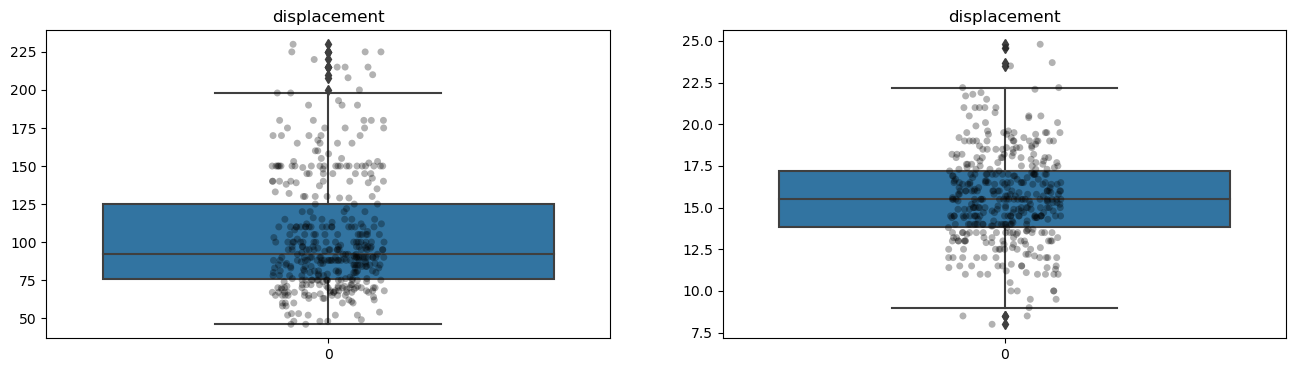

In [34]:
# Checking more details about outliers:
plt.figure(figsize=(16, 4))
for count, feature in enumerate(outliers):
    plt.subplot(1, len(outliers), count+1)
    sns.boxplot(data = df[feature])
    sns.stripplot(color = 'black', alpha = 0.3, data = df[feature])
    plt.title(i)
plt.show()



## Preprocessing 

In [36]:
# Removing outliers
def remove_outlier(df, outliers):
    """
    df: dataframe
    outliers: outliers
    """
    
    print("The outliers are :", outliers)
    
    print("Removing outliers ......")
    for col in outliers:
        first_q = np.percentile(df[col], 25)
        third_q = np.percentile(df[col], 75) 
        #IQR = 1.5*(third_q - first_q)
        IQR = (third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
    
        median = df[col].median()
    
        df.loc[df[col] < minimum, col] = median 
        df.loc[df[col] > maximum, col] = median
    return df

In [37]:
df_new = remove_outlier(df, outliers)

print("Size of the dataset before remove outlier: {}".format(df.shape))
print("Size of the dataset after remove outlier: {}".format(df_new.shape))
df.head(10)

The outliers are : ['horsepower', 'acceleration']
Removing outliers ......
Size of the dataset before remove outlier: (398, 9)
Size of the dataset after remove outlier: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""
5,15.0,8,429.0,92.0,4341.0,15.5,70,1,"""ford galaxie 500"""
6,14.0,8,454.0,92.0,4354.0,15.5,70,1,"""chevrolet impala"""
7,14.0,8,440.0,92.0,4312.0,15.5,70,1,"""plymouth fury iii"""
8,14.0,8,455.0,92.0,4425.0,15.5,70,1,"""pontiac catalina"""
9,15.0,8,390.0,92.0,3850.0,15.5,70,1,"""amc ambassador dpl"""


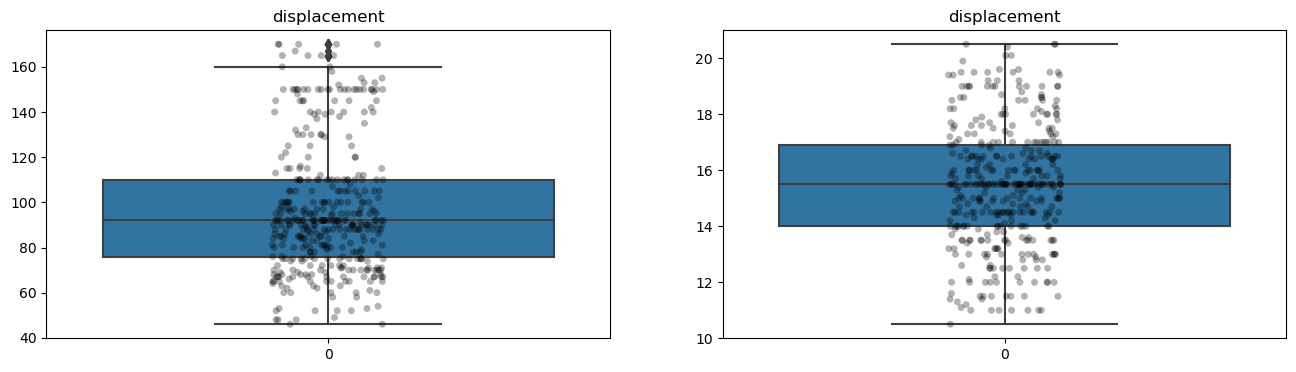

In [38]:
# Checking more details about outliers:
plt.figure(figsize=(16, 4))
for count, feature in enumerate(outliers):
    plt.subplot(1, len(outliers), count+1)
    sns.boxplot(data = df_new[feature])
    sns.stripplot(color = 'black', alpha = 0.3, data = df_new[feature])
    plt.title(i)
plt.show()

In [39]:
df_new.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


In [40]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [43]:
df_new.to_csv('./dataset/df_new.csv')

In [ ]:
df.head()

In [ ]:
#df['horsepower']

plot = sns.lmplot(x = 'horsepower', y = "mpg", data = df.where(df['origin'] == 1))
#plot = sns.lmplot(x = "mpg", y = i, data = df, hue = 'origin')
plt.title('horsepower' + ' vs ' + 'mpg', fontsize = 15)
plt.show()
    

In [ ]:
for i in ["acceleration","weight","displacement"]:
    #plot = sns.lmplot(x = i, y = "mpg", data = df)
    plot = sns.lmplot(x = "mpg", y = i, data = df, hue = 'origin')
    plt.title(i + ' vs ' + 'mpg', fontsize = 15)
    plt.show()

In [ ]:
df.where(df['origin'] == 1)

In [ ]:
for i in ["acceleration","weight","displacement"]:
    plot = sns.lmplot(x = i, y = "mpg", data = df.where(df['origin'] == 1))
    #plot = sns.lmplot(x = "mpg", y = i, data = df, hue = 'origin')
    plt.title(i + ' vs ' + 'mpg', fontsize = 15)
    plt.show()

In [ ]:
for i in ["acceleration","weight","displacement"]:
    plot = sns.lmplot(x = "mpg", y = i, data = df, hue = 'origin')
    plt.title(i, fontsize = 15)
    plt.show()

# References
- dataset source: https://archive.ics.uci.edu/static/public/9/auto+mpg.zip
- https://www.kaggle.com/code/merturper/vehicle-fuel-consumption-eda-stats-ml
- https://www.kaggle.com/code/filizesenkaya/car-eda